### **Author: Jacobo Padín Martínez**

# An introduction to the Variational Quantum Eigensolver

this is based on the homework of the Master in Quantum Science and Technology at UB

In this homework we will use the Variational Quantum Eigensolver (VQE) to find the ground state of an Ising Hamiltonian, following the steps

1. Initialization: construct a reference state
2. Parametrized quantum circuit: build a variational ansatz
3. Cost function: implement measurements
4. Classical optimization of the parameters

To obtain the final result, we iterate until convergence.

# Setup 

For this tutorial, we will use [Qiskit](https://www.ibm.com/quantum/qiskit), which is an IBM open-source python library for gate based quantum computing.

In order to install Qiskit, you need to use pip:

    !pip install qiskit
    !pip install qiskit-ibm-runtime

> Once this is installed, restart the kernel and you are ready to start!

To understand a bit better how to build circuits with Qiskit, a good idea is to check the [IBM Quantum Composer](https://quantum.ibm.com/composer/files/new). Open the link and go to _getting started_ -> _create your first circuit walkthrough_.

This will take you through the initial steps to build a Bell state and then measure it to see the probabilities. You should see that the probabilities are splitted $50\%$ in the state $\ket{00}$ and $50\%$ in the state $\ket{11}$. Make sure to choose the Qiskit option to see how the code is written.  

The resulting code should look as follows:


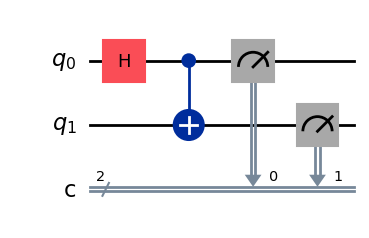

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler, Estimator #measuring can be done using Sampler or Estimator
from numpy import pi

qreg_q = QuantumRegister(2, 'q') # initialize the quantum register with number of qubits
creg_c = ClassicalRegister(2, 'c') # initialize classical register to measure
circuit = QuantumCircuit(qreg_q, creg_c) # composed circuit

circuit.h(qreg_q[0]) # add Hadamard gate
circuit.cx(qreg_q[0], qreg_q[1]) # add C-NOT gate / J: control[0] and not in [1]
circuit.measure(qreg_q[0], creg_c[0]) # measure Qubit 1
circuit.measure(qreg_q[1], creg_c[1]) # measure Qubit 2

# draw the circuit
circuit.draw("mpl")

In [2]:
# check the output using the sampler
sampler = Sampler()
job = sampler.run(circuit)
# J: Sampler().run(circuit) is also a valid code
# print(job.result())
probability_dists = job.result().quasi_dists # get prob distributions
print('The probability distribution is ', probability_dists)

The probability distribution is  [{0: np.float64(0.5), 3: np.float64(0.5)}]


/tmp/ipykernel_7939/480454536.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## The transverse field Ising model (TFIM)

Consider a chain of quantum spins. The state of each spin is given by $\alpha \ket{0} + \beta \ket{1}$, where $\alpha$ and $\beta$ are complex amplitudes, and it can be represented by a qubit (Bloch sphere).

The Hamiltonian of this system is given as follows:

$H = -\sum_{<i,j>} Z_i Z_j - h\sum_i X_i$,

where $Z_i$ is the Pauli matrix $Z$ applied to site $i$ and $X_i$ is the Pauli matrix $X$ applied to site $i$:

$X = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}$, 
$Z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}$. 

Note that the Pauli matrices and the tensor products between them are easily imported with Qiskit using

    from qiskit.quantum_info import SparsePauliOp
    X = SparsePauliOp('X')
    ZZ = SparsePauliOp('ZZ')

## Variational quantum eigensolver

We want to solve the Schrödinger equation $H\ket{\psi_0} = E_0\ket{\psi_0}$ to find the energy of the ground state. In particular, the Hamiltonian $H$ describes a system which minimizes the energy when all spins align to their neighbors in the $Z$ direction, but at the same time when the external field $h$ is finite, the spins want to align with the $X$ direction of the Bloch sphere. Since we have competing forces, finding the ground state can become a complex optimization problem.

In this tutorial we will use VQE, which relies on the variational principle

$E_0 \leq \frac{\bra{\psi} H \ket{\psi}}{\bra{\psi}\ket{\psi}}$.

The goal will be to minimize the energy of the ansatz state $\ket{\psi}$, which is given by $E = \bra{\psi} H \ket{\psi}$.

### Some references:

> [Here](https://learning.quantum.ibm.com/course/variational-algorithm-design) you can find most of the details about variational quantum algorithms discussed in the lectures exemplified using Qiskit.

> In [these](https://arxiv.org/pdf/2204.04198.pdf) notes on machine learning for physics there is a section where they introduce quantum algorithms and, in particular, VQE.

> To go a bit further, this [paper](https://arxiv.org/pdf/2012.09265.pdf) discusses the state of the art of variational quantum algorithms. 

## The task

### Step 1: Build the Hamiltonian

Start by importing numpy and matplotlib. From Qiskit you are going to need (for now) the Pauli operators 

    from qiskit.quantum_info import SparsePauliOp
    
Build the Hamiltonian for 3 qubits and different values of the external field $h$ (0.5,1 and 1.5). 
Note that you basically need to make a list of the operators with their corresponding coefficients, where each operator is a tensor product of some Paulis and identities everywhere else!

As a benchmark, run exact diagonalization on the Hamiltonian. An easy option is to convert the operator to a matrix using `hamiltonian.to_matrix()` and then use an eigensolver. Save the ground state energy and the ground state for each of the values of the external field.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
import scipy as scp

# Auxiliar functions that may are usefull
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.primitives import Sampler, Estimator #measuring can be done using Sampler or Estimator


# Define the number of qubits
n_qubits = 3
# Define the values of the external field
h_values = [0.5, 1, 1.5]

# Define the Pauli matrices
I = SparsePauliOp('I')
X = SparsePauliOp('X')
Z = SparsePauliOp('Z')

term1 = [(Z.tensor(Z)).tensor(I), (I.tensor(Z)).tensor(Z)]
term2 = [(X.tensor(I)).tensor(I),(I.tensor(X)).tensor(I),(I.tensor(I)).tensor(X)]

hamiltonian_list= [-sum(term1) - h*sum(term2) for h in h_values] # Each term of this list is a hamiltonian with h = 0.5, 1.0, 1.5
print('List of the Hamiltonians\n',hamiltonian_list)
print('-'*140)

eigenvalues=[]
eigenstates=[]

for hamiltonian in hamiltonian_list:
    H = hamiltonian.to_matrix()
    aux = np.linalg.eig(H)

    eigenvalues.append(aux[0])
    eigenstates.append(aux[1]) 


List of the Hamiltonians
 [SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[-1. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j]), SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j]), SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IIX'],
              coeffs=[-1. +0.j, -1. +0.j, -1.5+0.j, -1.5+0.j, -1.5+0.j])]
--------------------------------------------------------------------------------------------------------------------------------------------


### Step 2: Build the ansatz (parametrized quantum circuit)

We can use different types of ansatz for our VQE.

One option is to use the two-local circuit defined [here](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal) to build an ansatz similar to the one we discussed in the lectures.

But feel free to explore any of the options [here](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits). Note that you might want to use short circuits to get the optimization done.

Use `ansatz.decompose().draw("mpl")` to see the circuit.


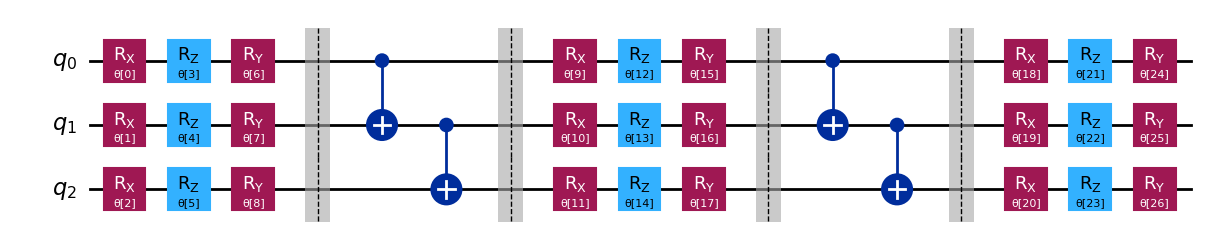

In [4]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(3, ['rx','rz','ry'], 'cx', 'linear', reps=2, insert_barriers=True)
# ansatz=TwoLocal(3,['ry','rz'],'cx',reps=3,insert_barriers=False)

ansatz.decompose().draw("mpl") 

# This creates the |psi(theta)> for which we will calculate <H>(theta), and then repeat until find the minimum


### Step 3: Define the classical optimizer 

Choose one of the [optimizers defined in qiskit](https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers) to run the classical optimization. Typical choices include SLSQP, COBYLA, SPSA, L_BFGS_B or ADAM. Explore a bit what are their characteristics (are they local or global, do they use the gradient or not, etc).
 

In [5]:
from qiskit_algorithms.optimizers import ADAM,SLSQP,SPSA

# optimizer = ADAM(maxiter=5000)
optimizer = SLSQP(maxiter=50)
# optimizer = SPSA(maxiter=5000)

# I tried with the three optimizers, and the best results were with SLSQP


### Step 4: VQE without noise

Import the Estimator from the [qiskit_aer.primitives](https://docs.quantum.ibm.com/api/qiskit/primitives), which will allow us to simulate the circuit in our computer. 

> If we wanted to run it on a real device, we would need to import the primitives using [QiskitRuntimeService](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService). This allows us to acces the small devices in the [IBM Quantum platform](https://quantum.ibm.com/). If you want to check it an create an account, you have 10 minutes of computing time for free.

Set the estimator without noise and the number of shots used to compute the expectation values. Then, you can use the [VQE routine](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.VQE.html) to compute the minimum eigenvalue of the operator. Save the intermediate results and plot the value of the cost throughout the iterations to see how the algorithm converges.

> Before running the VQE, it is useful to fix the random seed 

        seed = 170
        algorithm_globals.random_seed = seed

Run it for different values of the external field (0.5, 1 and 1.5), and save the results.


**After see the final results, I concluded the ADAM estimator didn't work well, so I will repeat this with SLSQP**

### SLSQP optimizer

/tmp/ipykernel_7939/3897129334.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  VQE_process = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=optimizer, callback=save_data)
/tmp/ipykernel_7939/3897129334.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  VQE_process = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=optimizer, callback=save_data)
/tmp/ipykernel_7

--------------------------------------------------------------------------------
h = 0.5
Theta parameters
 [ 2.36423219  5.64246866  4.13505553  5.18732726 -3.66842659  5.96914415
 -5.7769652  -4.91254269  2.27055035  3.25714409  5.15594164  5.05492297
 -4.73512327 -0.15862228 -1.21601172 -4.60927506 -0.23133083 -4.94831423
 -4.83717988  3.70864212 -5.17602361  2.74629562  4.39421965 -1.92501463
  1.08796407 -4.29341287 -1.75770701]
Eigenvalue = Ground state energy = -2.403211692102578
--------------------------------------------------------------------------------
h = 1
Theta parameters
 [-0.82885327 -2.57721069  3.91911765  2.74563905 -0.11916861 -0.45439468
 -2.14913565  6.17065099  4.72826276 -0.06375323  5.36771441 -4.59062349
  0.83467559 -3.67646136 -6.15642203 -3.83758162 -3.65615941 -1.56779152
  1.7632159   3.10863839 -0.60529925  5.81188944 -3.96247972  5.15977633
 -2.60466023  0.97369469 -2.47393041]
Eigenvalue = Ground state energy = -3.493958906688441
--------------------

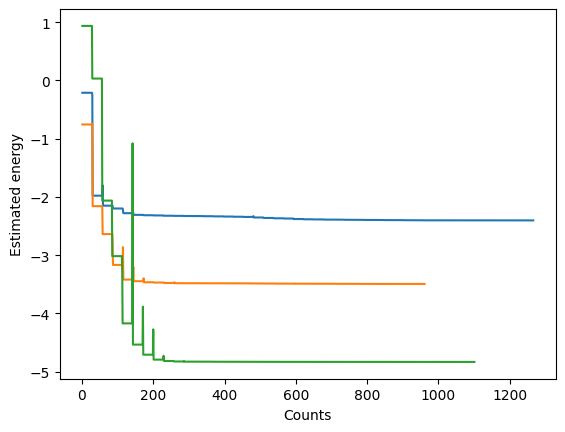

In [7]:
from qiskit.primitives import Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals

seed=170
algorithm_globals.random_seed=seed

# ansatz = TwoLocal(3, ['ry','rz','ry'], 'cx', 'linear', reps=2, insert_barriers=True)
# optimizer = SLSQP(maxiter=50)

def save_data(eval_count, opt_parameters, estimated_value, metadata_dict):
    count.append(eval_count)
    estimated_energy.append(estimated_value)

plt.figure()
VQE_eigenvalues=[]

for H in hamiltonian_list:
    count=[]
    estimated_energy=[] 
    VQE_process = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=optimizer, callback=save_data)
    VQE_eigenvalues.append(VQE_process.compute_minimum_eigenvalue(H))
    
    plt.plot(count,estimated_energy)

plt.ylabel('Estimated energy')
plt.xlabel('Counts')

VQE_optimal_parameters=[]

i=0
for result in VQE_eigenvalues:
    print('-'*80)
    print('h =',h_values[i])
    i+=1
    print('Theta parameters\n', result.optimal_point)
    VQE_optimal_parameters.append(result.optimal_point)
    print('Eigenvalue = Ground state energy =',result.eigenvalue)

SLSQP is WAY faster than ADAM in terms of computational time


### Step 5: Study of the ground state for different values of h

Once the three simulations converged, save the optimal parameters for each of them.

Applying the ansatz circuit to the reference state $\ket{0}^{\otimes 3}$ with each of the optimal parameter vector, you will obtain the ground state. Using sampler (as shown before), look at the probability density of the ground states and compare them.

In [8]:
qreg_q = QuantumRegister(3, 'q') # initialize the quantum register with number of qubits
creg_c = ClassicalRegister(3, 'c') # initialize classical register to measure

# ansatz = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)

circuit = QuantumCircuit( qreg_q , creg_c)
circuit.append(ansatz, qargs=[0,1,2])
circuit.decompose().draw("mpl")

circuit.measure(circuit.qubits[0],creg_c[0]) #Measure the three qubits and store the information in the classical channels.
circuit.measure(circuit.qubits[1],creg_c[1])
circuit.measure(circuit.qubits[2],creg_c[2])

# check the output using the sampler
sampler = Sampler()

VQE_prob_distr=[]
for i in range(len(VQE_optimal_parameters)):
    job = sampler.run(circuit,VQE_optimal_parameters[i])
    # J: Sampler().run(circuit) is also a valid code
    # print(job.result())
    probability_dists = job.result().quasi_dists # get prob distributions
    print('The probability distribution for:') 
    print('h=%f'%h_values[i])
    print('%s'%probability_dists)
    print('\n')
    VQE_prob_distr.append(probability_dists)
    

The probability distribution for:
h=0.500000
[{0: np.float64(0.407791233012491), 1: np.float64(0.039396609403969), 2: np.float64(0.013834737523303), 3: np.float64(0.039354270214141), 4: np.float64(0.039440344458693), 5: np.float64(0.013811227912937), 6: np.float64(0.039362555417568), 7: np.float64(0.407009022056899)}]


The probability distribution for:
h=1.000000
[{0: np.float64(0.283760572969533), 1: np.float64(0.087413039733523), 2: np.float64(0.04181298473564), 3: np.float64(0.087335932873597), 4: np.float64(0.08731191324972), 5: np.float64(0.041817104700633), 6: np.float64(0.087294996262322), 7: np.float64(0.283253455475032)}]


The probability distribution for:
h=1.500000
[{0: np.float64(0.226620940379488), 1: np.float64(0.106117998032687), 2: np.float64(0.061306997436029), 3: np.float64(0.105999936176434), 4: np.float64(0.106116379264696), 5: np.float64(0.061212799837985), 6: np.float64(0.105991661691841), 7: np.float64(0.226633287180841)}]




/tmp/ipykernel_7939/52307374.py:15: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


### Step 6: VQE with noise

Now we will run the same simulations but adding a noise model from a fake device. We start by importing:

    from qiskit_aer.noise import NoiseModel
    from qiskit.providers.fake_provider import FakeVigo

Then we can define the device as `device=FakeVigo()` and take its coupling map `coupling_map = device.configuration().coupling_map` and the noise model `noise_model = NoiseModel.from_backend(device)`. Print the noise model to see its properties.

Once this is set, the AerEstimator can be defined to mimic the fake device and then we can run the algorithm as before, storing the results for different values of the external field.

Text(0.5, 0, 'Counts')

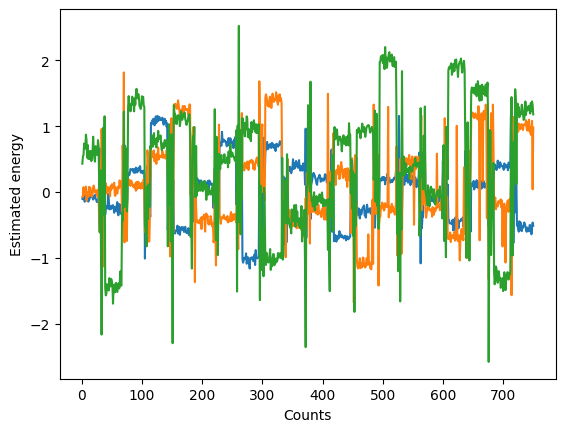

In [21]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import*
from qiskit_aer.primitives import Estimator as AerEstimator
import matplotlib.pyplot as plt

device=FakeVigoV2()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(backend_options={"method": "density_matrix","coupling_map": coupling_map,"noise_model": noise_model,})
optimizer=SLSQP(maxiter=20)

plt.figure()
noisy_eigenvalues=[]

for H in hamiltonian_list:
    count=[]
    estimated_energy=[] 
    
    VQE_process = VQE(estimator=noisy_estimator, ansatz=ansatz, optimizer=optimizer, callback=save_data)
    noisy_eigenvalues.append(VQE_process.compute_minimum_eigenvalue(H))
    
    plt.plot(count,estimated_energy)

plt.ylabel('Estimated energy')
plt.xlabel('Counts')

In [22]:
noisy_optimal_parameters=[]

i=0
for result in noisy_eigenvalues:
    print('-'*80)
    print('h =',h_values[i])
    i+=1
    print('Theta parameters\n', result.optimal_point)
    noisy_optimal_parameters.append(result.optimal_point)
    print('Eigenvalue = Ground state energy =',result.eigenvalue)

--------------------------------------------------------------------------------
h = 0.5
Theta parameters
 [  4132558.196221     1268545.82162963 -18065963.22150688
  17293917.88041265 -35808816.08959418   5338980.52925928
 -11475502.92530796 -61305982.82108267 -55298750.75068595
  30385424.13172992 -10499021.96268474  -5286309.52441993
 -35844376.4574126  -34962600.69767318 -12535150.38548877
 -46678786.21156069 -15430729.4920143    5391435.80293928
 -20090773.0725415     134385.47707217 -24368044.44210521
 -19595846.82110942   9253378.66877931  34102853.01436643
  29990247.90979684  29366895.74183467 -39404705.73774832]
Eigenvalue = Ground state energy = -0.5126953125
--------------------------------------------------------------------------------
h = 1
Theta parameters
 [-1.07505169e+08  3.68600627e+07 -8.26464782e+06 -8.55490953e+07
 -7.30541102e+07 -3.56429409e+07 -1.17164173e+08  4.06081652e+05
  1.70008998e+07  6.23935975e+07  1.08422459e+07 -7.31016290e+07
 -1.00694197e+07  1.5

In [33]:
qreg_q = QuantumRegister(3, 'q') # initialize the quantum register with number of qubits
creg_c = ClassicalRegister(3, 'c') # initialize classical register to measure

# ansatz=TwoLocal(3,['ry','rz'],'cx',reps=3,insert_barriers=False)

circuit = QuantumCircuit( qreg_q , creg_c)
circuit.append(ansatz, qargs=[0,1,2])
circuit.decompose().draw("mpl")

circuit.measure(circuit.qubits[0],creg_c[0]) #Measure the three qubits and store the information in the classical channels.
circuit.measure(circuit.qubits[1],creg_c[1])
circuit.measure(circuit.qubits[2],creg_c[2])


# check the output using the sampler
sampler = Sampler()


noisy_prob_distr=[]
for i in range(len(noisy_optimal_parameters)):

    job = sampler.run(circuit, noisy_optimal_parameters[i])
    # J: Sampler().run(circuit) is also a valid code
    # print(job.result())
    probability_dists = job.result().quasi_dists # get prob distributions
    print('The probability distribution for:') 
    print('h=%f'%h_values[i])
    print('%s'%probability_dists)
    print('\n')
    noisy_prob_distr.append(probability_dists)

ValueError: A backend or session must be specified.

### **Exact diagonalization and results comparison**

In [34]:
import numpy as np
i=0
for H in hamiltonian_list:
    eigenvalues=[]
    eigenstates=[]
    Hamiltonian = H.to_matrix()
    aux = np.linalg.eig(Hamiltonian)
    eigenvalues.append(aux[0])
    eigenstates.append(aux[1])
    
    diag_eigenvalues=-np.array(eigenvalues)[0]
    diag_eigenstates=np.array(eigenstates)[0][0]
    
#    probabilities=(diag_eigenstates*np.conjugate(diag_eigenstates))
    
    print('\n')
    print('-'*80)
    print('h=',h_values[i])
    
    print('\n\n-Ground state prob density')
#    print('\nDiag:',  probabilities)
    print('VQE:', VQE_prob_distr[i])
    print('Noisy:', noisy_prob_distr[i])
    
    print('\n\n-Ground state energy')
    print('\nDiag:', -diag_eigenvalues[0]) 
    print('VQE:', VQE_eigenvalues[i].eigenvalue)
    print('Noisy:', noisy_eigenvalues[i].eigenvalue)

    i+=1



--------------------------------------------------------------------------------
h= 0.5


-Ground state prob density
VQE: [{0: np.float64(0.407791233012491), 1: np.float64(0.039396609403969), 2: np.float64(0.013834737523303), 3: np.float64(0.039354270214141), 4: np.float64(0.039440344458693), 5: np.float64(0.013811227912937), 6: np.float64(0.039362555417568), 7: np.float64(0.407009022056899)}]


NameError: name 'noisy_prob_distr' is not defined

**The ground state energy is incredibly near to the exact value, up to the 6 digit.**

At h = 0.5, the most probable states are $\ket{000}$ and $\ket{111}$, with a probability of $\simeq 0.4$. The other states have a probability in the order of $10^{-2}$. This means the system is in the ferromagnetic region, since 000 and 111 mean the three spins are in the same direction.

At h = 1.5, the magnetic field is so strong (in the X direction) that 000 and 111 have a probability of the same order as 001, 011, 100 or 110, so the spins start to not align in the Z axis. We see that the 010 and 101 configurations are less likely, this is the effect of the second spin interacting with the other two spins (nearest neighbors), while the first and third only interact with the second.
